In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import matplotlib.lines as mlines
import plotly.express as px

# Context and Purpose

We aim to evaluate the statistical truth around the saying "we observe more childbirth on full moon periods". 
We found data available for Belgium from year 1992 to 2021, but our statistical analysis is set on year 2019.

# Let's read and select our data...

In [3]:
data = pd.read_excel("TF_BIRTHS.xlsx", parse_dates=True)
data.rename(columns={"DT_DATE": "date", "MS_NUM_BIRTHS": "nb_birth"}, inplace=True)
print(data)
data.info()
data.describe()
# une moyenne de 123 800 naissances par an (sur les 29 ans enregistrées) -> cohérent

            date  nb_birth
0     1992-01-01       219
1     1992-01-02       331
2     1992-01-03       420
3     1992-01-04       282
4     1992-01-05       252
...          ...       ...
10953 2021-12-27       341
10954 2021-12-28       377
10955 2021-12-29       338
10956 2021-12-30       325
10957 2021-12-31       229

[10958 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10958 entries, 0 to 10957
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      10958 non-null  datetime64[ns]
 1   nb_birth  10958 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 171.3 KB


c:\Users\Utilisateur\anaconda3\envs\libDataScience\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,nb_birth
count,10958.000000
mean,327.624019
std,80.125454
min,148.000000
25%,237.000000
50%,358.000000
75%,389.000000
max,493.000000


A quick calculation gives us a mean of 123 800 birth per year on the 29 year of the data. This is coherent with the official number of childbirth per year : 117 914 on 2021

# Let's visualize what we are dealing with...

            date  nb_birth
9862  2019-01-01       206
9863  2019-01-02       327
9864  2019-01-03       338
9865  2019-01-04       358
9866  2019-01-05       215
...          ...       ...
10222 2019-12-27       392
10223 2019-12-28       204
10224 2019-12-29       207
10225 2019-12-30       310
10226 2019-12-31       302

[365 rows x 2 columns]


<AxesSubplot: title={'center': 'Fig 1 : First plot of raw data for year 2019'}, xlabel='date', ylabel='nb_birth'>

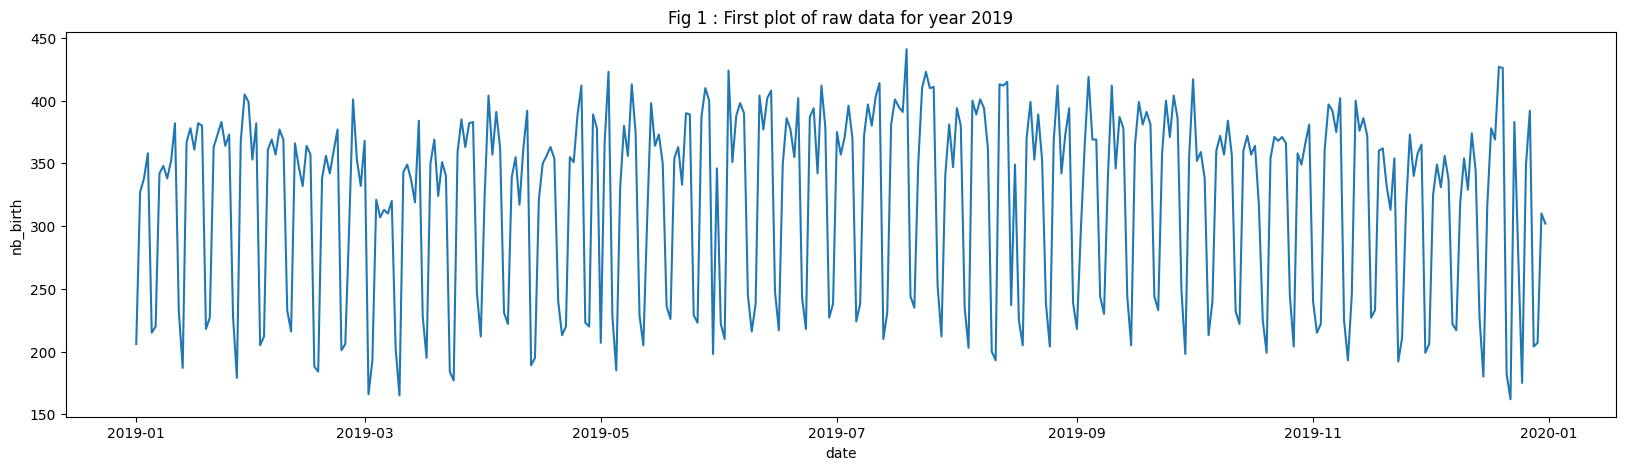

In [4]:
# print raw and smoothed data for 2019
annee = 2019
sub_data = data[data["date"].dt.year == annee].copy()
print(sub_data)

plt.figure(figsize=(20, 5))
plt.title("Fig 1 : First plot of raw data for year 2019")
sns.lineplot(data=sub_data, x="date", y="nb_birth")

This is not what we expected, the number of childbirth per day is periodical and very noisy. A possible explaination could be that the data takes in the induced labors and, as the hospital is working with reduced teams on week-end and public holidays, the number of births drops. 

# Let's plot week-ends and public holidays on our graph...

In [5]:
# get the sundays of 2019
df_sundays = pd.DataFrame({"date": pd.date_range("2019-01-01", "2019-12-31")})
df_sundays["is_sunday"] = df_sundays["date"].dt.day_of_week == 6
df_sundays["value"] = df_sundays.is_sunday.map({True: 1000, False: 0})
print(df_sundays)

# get public holidays of 2019
public_holidays = pd.DataFrame(
    {
        "date": [
            "2019-01-01",
            "2019-04-22",
            "2019-05-01",
            "2019-05-30",
            "2019-06-10",
            "2019-07-21",
            "2019-08-15",
            "2019-11-01",
            "2019-11-11",
            "2019-12-25",
        ]
    }
)
public_holidays["date"] = pd.to_datetime(public_holidays["date"])

          date  is_sunday  value
0   2019-01-01      False      0
1   2019-01-02      False      0
2   2019-01-03      False      0
3   2019-01-04      False      0
4   2019-01-05      False      0
..         ...        ...    ...
360 2019-12-27      False      0
361 2019-12-28      False      0
362 2019-12-29       True   1000
363 2019-12-30      False      0
364 2019-12-31      False      0

[365 rows x 3 columns]


Text(0.5, 1.0, 'Fig 2 : Impact of week-ends and public holidays on birth count')

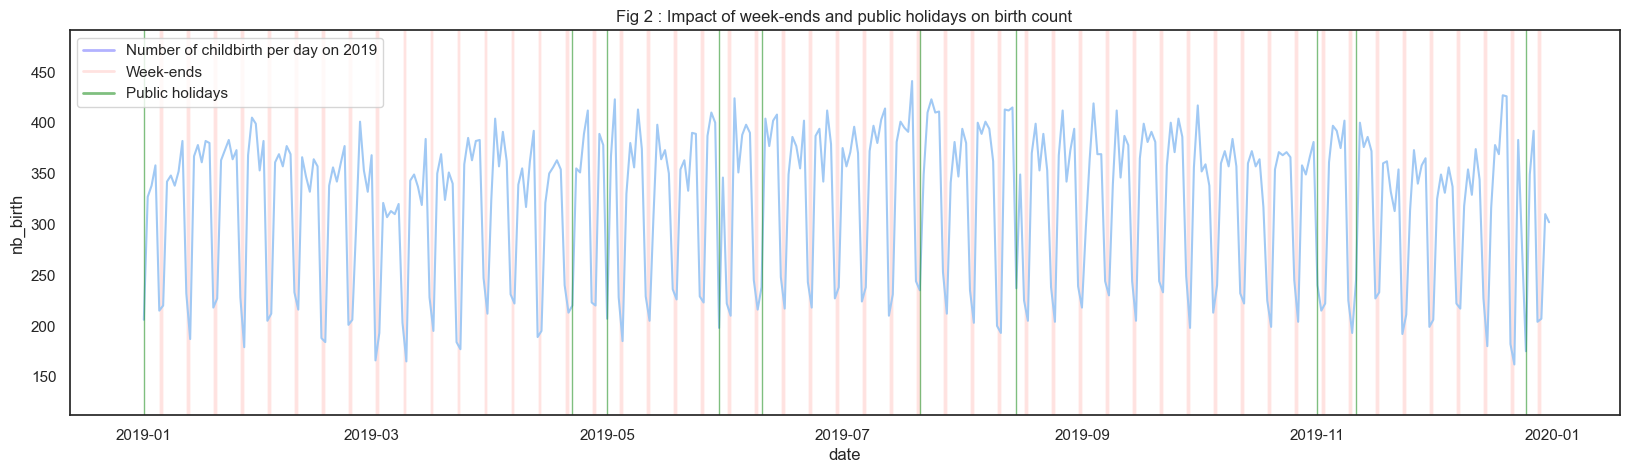

In [6]:
plt.figure(figsize=(20, 5))

sns.set_theme(style="white", palette="pastel")
sns.lineplot(data=sub_data, x="date", y="nb_birth")

# plot vertical line for public holidays
for i in range(len(public_holidays)):
    line = public_holidays.iloc[i]
    date = line["date"]
    plt.axvline(date, color="green", linewidth=1, alpha=0.5)

# plot color bar for sundays (variante with barplot)
plt.bar(
    x=df_sundays["date"],
    height=df_sundays["value"],
    color="r",
    alpha=0.3,
    width=-1,
    align="edge",
)
plt.ylim(min(sub_data["nb_birth"]) - 50, max(sub_data["nb_birth"]) + 50)

plt.legend(
    handles=[
        mlines.Line2D(
            [],
            [],
            color="blue",
            alpha=0.3,
            linewidth=2,
            markersize=15,
            label="Number of childbirth per day on 2019",
        ),
        mlines.Line2D(
            [],
            [],
            color="r",
            alpha=0.3,
            linewidth=2,
            markersize=15,
            label="Week-ends",
        ),
        mlines.Line2D(
            [],
            [],
            color="green",
            alpha=0.5,
            linewidth=2,
            markersize=15,
            label="Public holidays",
        ),
    ]
)

plt.title("Fig 2 : Impact of week-ends and public holidays on birth count")

Ok, every drops corresponds to a period of reduced teams. We now need to smoothen the data to evaluate the variations during the year. We have two possibilities : 1D gaussian filter or a rolling mean with a period of 7 days.

# Let's apply these on the data...

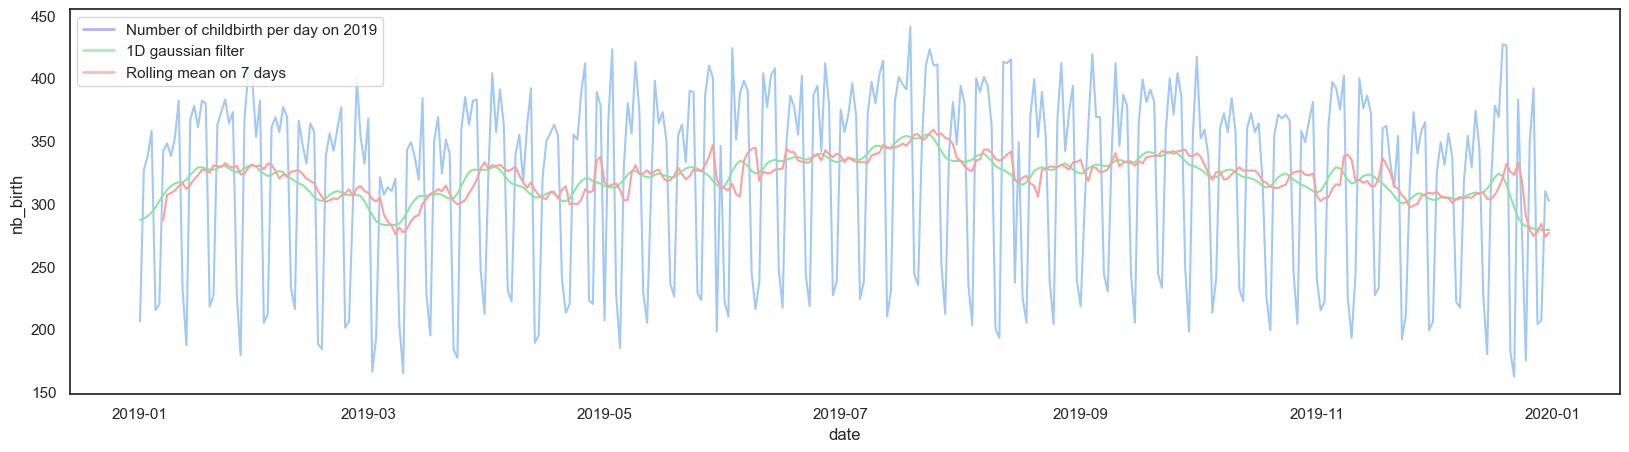

In [7]:
sigma = 3  # empirical, balance to keep noise low
sub_data["smooth_gaussian"] = gaussian_filter1d(
    np.array(sub_data["nb_birth"]), sigma=sigma
).round(1)
sub_data["smooth_rolling_mean"] = sub_data.nb_birth.rolling(7).mean().round(1)

plt.figure(figsize=(20, 5))

sns.set_theme(style="white", palette="pastel")
sns.lineplot(data=sub_data, x="date", y="nb_birth")
sns.lineplot(data=sub_data, x="date", y="smooth_gaussian", color="g")
sns.lineplot(data=sub_data, x="date", y="smooth_rolling_mean", color="r")

plt.legend(
    handles=[
        mlines.Line2D(
            [],
            [],
            color="blue",
            alpha=0.3,
            linewidth=2,
            markersize=15,
            label="Number of childbirth per day on 2019",
        ),
        mlines.Line2D(
            [],
            [],
            color="g",
            alpha=0.7,
            linewidth=2,
            markersize=15,
            label="1D gaussian filter",
        ),
        mlines.Line2D(
            [],
            [],
            color="r",
            alpha=0.7,
            linewidth=2,
            markersize=15,
            label="Rolling mean on 7 days",
        ),
    ]
)

The two smoothen curves are close but the rolling mean sticks better to the reality of the data and keeps in small variations. In fact the rolling mean is based on existing values, when the gaussian filter apply a theorical filtering window to smoothen the data. Compared to context, it make more sens to keep consistent the number of childbirths on a week with the rolling mean. Moreover, the induced lack of the 7 first days of the year represente only 2 % of the total days.

We now can easily observe the evolution of childbirth during 2019. It would be interesting to compare the years with each other, to emprically confirm that 2019 is not extraordinary. 

# Let's plot the 10 last years...

In [8]:
# certaines années sont bissextiles, donc avec un nb differents de jours.
# on change de preprocessing pour caler toutes les années sur les jours de 2019 (non bissextile)
# -> on passe les jours en colonne

ROLLING_PERIOD = 7
START_YEAR = 2012

df_per_year = pd.DataFrame(
    {"date": pd.date_range("2019-01-01", "2019-12-31").strftime("%d/%m")}
)

for year in data.date.dt.year.unique():
    if year >= START_YEAR:
        tmp = data[data.date.dt.year == year].copy()
        tmp["date"] = tmp["date"].dt.strftime("%d/%m")
        # on utilise la date en index (pour se simplifier la vie)
        tmp = tmp.set_index("date")
        # on applique la moyenne glissante
        tmp = tmp.rolling(ROLLING_PERIOD).mean()
        # on arrondie et reset l'index
        tmp = tmp.nb_birth.round(1).rename(year).reset_index()
        # on stock dans df_per_year date par date
        df_per_year = df_per_year.merge(tmp, on="date")

df_per_year["day_of_year"] = np.arange(len(df_per_year))

# on redéfini l'index avec la date et le decompte des jours
df_per_year = df_per_year.set_index(["date", "day_of_year"])

# on empile chaque colonne : chaque index a autant de ligne que de colonne.
# orga de nouvelles colonnes : [Index, année (ancienne colonne), valeurs]
df_per_year = df_per_year.stack()

# on sort les dates de l'index et on renomme les colonnes
df_per_year = df_per_year.reset_index().rename(
    columns={"level_2": "year", 0: "nb_birth_roll"}
)

In [9]:
# plot avec plotly de toutes les années depuis 2012 (interactif)

px.line(
    df_per_year,
    x="day_of_year",
    y="nb_birth_roll",
    color="year",
    range_y=[0, df_per_year.nb_birth_roll.max()],
    hover_data=df_per_year.columns,
    title="Fig 3 : number of childbirth from 2012 to 2021 (smoothen) ",
)

Regarding the magnitude of childbirths, 2019 is not different than other 2010's. We can stick with this year to analyse periods of the moon. As no dataset is available for the moon calendar of Belgium, I had to build it myself. It is the reason why we keep our study only on 2019.

We consider a moon period (full, half, new) lasting 3 days : the day before, the exact date, and the day after.

# Let's plot 2019 moon cycles... 

Text(0.5, 1.0, 'Plot of the cycles of the moon on 2019')

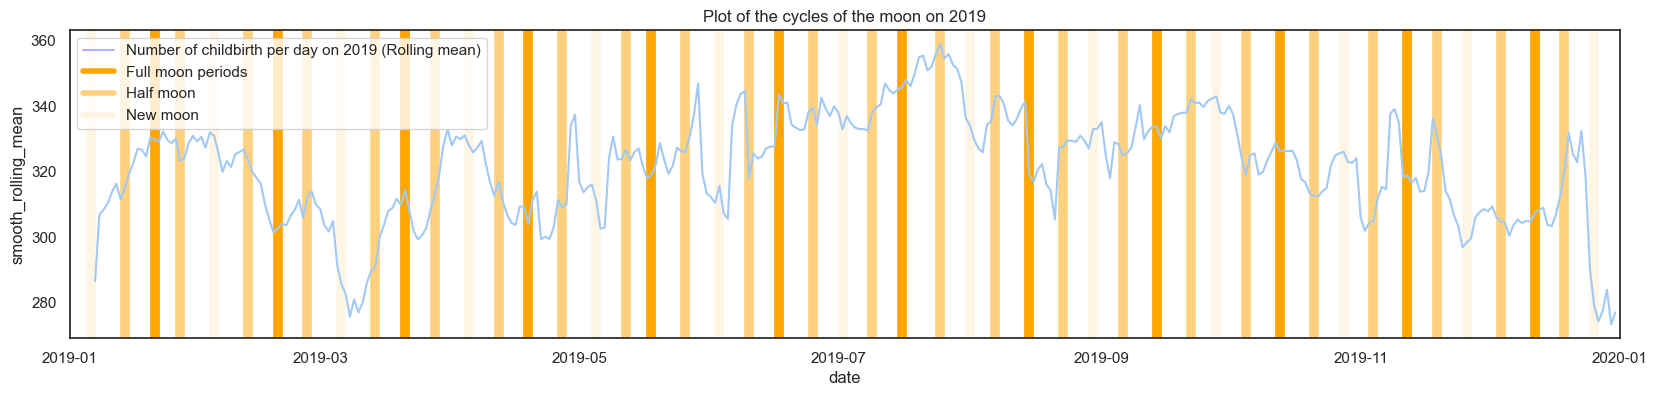

In [10]:
# moon calendar 2019
moon_2019 = pd.read_csv("moon2019.txt")

moon_2019["date"] = pd.to_datetime(moon_2019["date"])
moon_2019.head()

plt.figure(figsize=(20, 4))

for i in range(len(moon_2019)):
    line = moon_2019.iloc[i]
    date = line["date"]
    type = line["moon"]
    if type == 1:
        plt.axvline(date, color="orange", linewidth=7, alpha=1)
    elif type == 0.5:
        plt.axvline(date, color="orange", linewidth=7, alpha=0.5)
    elif type == 0:
        plt.axvline(date, color="orange", linewidth=7, alpha=0.1)

sns.lineplot(data=sub_data, x="date", y="smooth_rolling_mean", color="b")

plt.xlim(pd.to_datetime("2019-01-01"), pd.to_datetime("2020-01-01"))

plt.legend(
    handles=[
        mlines.Line2D(
            [],
            [],
            color="blue",
            alpha=0.3,
            markersize=15,
            label="Number of childbirth per day on 2019 (Rolling mean)",
        ),
        mlines.Line2D(
            [],
            [],
            color="orange",
            alpha=1,
            linewidth=4,
            markersize=15,
            label="Full moon periods",
        ),
        mlines.Line2D(
            [],
            [],
            color="orange",
            alpha=0.5,
            linewidth=4,
            markersize=15,
            label="Half moon",
        ),
        mlines.Line2D(
            [],
            [],
            color="orange",
            alpha=0.1,
            linewidth=4,
            markersize=15,
            label="New moon",
        ),
    ]
)

plt.title("Fig 4 : Plot of the cycles of the moon on 2019")

We now know the evolution of the moon during year 2019. For our study, we focus on full moon periods.

Is there an obvious rise of childbirth during full moon periods ?

# Now that we have all the data, we can answer that question...  

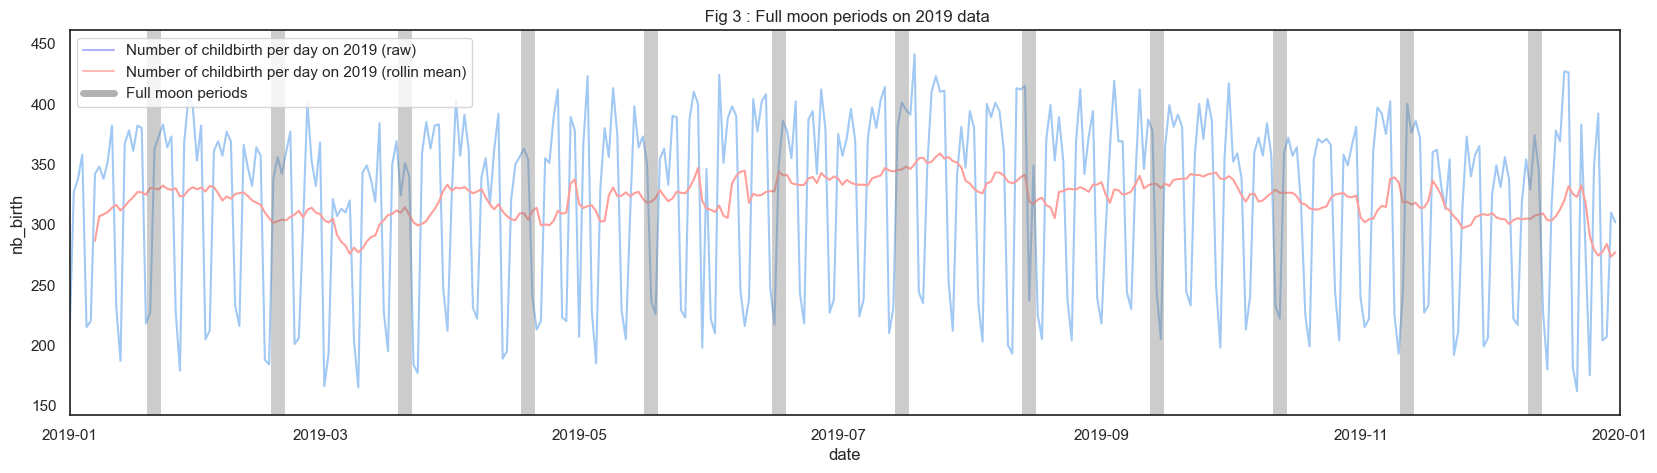

In [11]:
# final plot : 2019 filtered and unfiltered, full moons
import matplotlib.lines as mlines

plt.figure(figsize=(20, 5))

sns.set_theme(style="white", palette="pastel")
sns.lineplot(data=sub_data, x="date", y="nb_birth")
sns.lineplot(data=sub_data, x="date", y="smooth_rolling_mean", color="r")

# plot periods of full moon
for i in range(len(moon_2019)):
    line = moon_2019.iloc[i]
    date = line["date"]
    type = line["moon"]
    if type == 1:
        plt.axvline(date, color="grey", linewidth=10, alpha=0.4)


plt.ylim(min(sub_data["nb_birth"]) - 20, max(sub_data["nb_birth"]) + 20)
plt.xlim(pd.to_datetime("2019-01-01"), pd.to_datetime("2020-01-01"))

plt.title(" Fig 5 : Full moon periods on 2019 data")

# plot legend
plt.legend(
    handles=[
        mlines.Line2D(
            [],
            [],
            color="blue",
            alpha=0.3,
            markersize=15,
            label="Number of childbirth per day on 2019 (raw)",
        ),
        mlines.Line2D(
            [],
            [],
            color="r",
            alpha=0.7,
            markersize=15,
            label="Number of childbirth per day on 2019 (rollin mean)",
        ),
        mlines.Line2D(
            [],
            [],
            color="black",
            alpha=0.3,
            linewidth=5,
            markersize=15,
            label="Full moon periods",
        ),
    ]
)

Is is not obvious that full moon has an impact on the number of childbirth... To quantify this impact, we can try some statistical plots and tests, and be really sure about the significancy of a possible variation. 

First we need to split our data : one dataframe for full moon periods, another for the rest of the year. The week-ends and public holidays are a natural bias in our data, so we work with data smoothen by the rolling mean of 7 days for the rest of the evaluation. 

# Let's get statistical...

In [12]:
# creation des dataframe respectifs
df_moon_value = moon_2019[moon_2019["moon"] == 1]

df_moon_value = df_moon_value.date.apply(
    lambda x: pd.Series(
        pd.date_range(x - pd.Timedelta(days=1), x + pd.Timedelta(days=1))
    )
)

df_moon_value = (
    df_moon_value.stack()
    .drop_duplicates()
    .reset_index(level=[0, 1], drop=True)
    .to_frame(name="date")
)
df_moon_value = df_moon_value.merge(sub_data, on="date")
df_moon_value["type"] = ["moon"] * len(df_moon_value)

df_normal_value = pd.date_range("2019-01-01", "2019-12-31").to_frame(name="date")

mask = []
for day in pd.date_range("2019-01-01", "2019-12-31"):
    if (df_moon_value.date == day).any():
        mask.append(False)
    else:
        mask.append(True)

df_normal_value = df_normal_value[mask].reset_index(drop=True)
df_normal_value = df_normal_value.merge(sub_data, on="date")
df_normal_value["type"] = ["regular"] * len(df_normal_value)

df_stats = pd.concat([df_normal_value, df_moon_value]).reset_index()

We have our two dataframes. The first comparision would be the mean and standard deviation of the two sets. We also compute the confidence intervals at 5 % of the means, using t-student distribution. 

In [13]:
from scipy.stats import t, ttest_1samp

ALPHA = 0.05

# calcul des moyennes et IC des deux groupes
print("### Full moon period")
print(df_moon_value.describe())

intervalle_t_student_moon = ttest_1samp(
    a=df_moon_value["smooth_rolling_mean"].dropna(), popmean=0.5
)  # popmean n'a pas d'influence sur les IC
print(
    f"Intervalle de confiance sur la moyenne : {intervalle_t_student_moon.confidence_interval(confidence_level=1-ALPHA)}\n"
)

print("### Regular moon period")
print(df_normal_value.describe())

intervalle_t_student_reg = ttest_1samp(
    a=df_normal_value["smooth_rolling_mean"].dropna(), popmean=0.5
)  # popmean n'a pas d'influence sur les IC
print(intervalle_t_student_reg)
print(
    f"Intervalle de confiance sur la moyenne : {intervalle_t_student_reg.confidence_interval(confidence_level=1-ALPHA)}\n"
)

### Full moon period
         nb_birth  smooth_gaussian  smooth_rolling_mean
count   36.000000        36.000000            36.000000
mean   322.833333       321.138889           322.086111
std     65.729098        13.642691            13.661252
min    205.000000       302.000000           301.400000
25%    243.000000       308.000000           309.775000
50%    349.000000       321.000000           318.950000
75%    373.250000       330.500000           330.175000
max    415.000000       353.000000           347.900000
Intervalle de confiance sur la moyenne : ConfidenceInterval(low=317.4638085024883, high=326.7084137197339)

### Regular moon period
         nb_birth  smooth_gaussian  smooth_rolling_mean
count  329.000000       329.000000           323.000000
mean   320.610942       320.246201           321.395046
std     75.974286        15.502661            16.316540
min    162.000000       279.000000           273.400000
25%    233.000000       310.000000           310.200000
50%    

The values are close to each other and the means are included in each other's confidence interval. A boxplot is a good way to observe the distributions and key values of our data.

In [14]:
df_boxplot = pd.DataFrame(
    {
        "fullmoon": df_moon_value["smooth_rolling_mean"],
        "regular": df_normal_value["smooth_rolling_mean"],
    }
)
df_boxplot = (
    df_boxplot.stack()
    .reset_index()
    .drop(columns="level_0")
    .rename(columns={"level_1": "period", 0: "nb_birth_roll"})
)

px.box(
    df_boxplot,
    x="period",
    y="nb_birth_roll",
    points="all",
    title="Fig 6 : Boxplot of the 2 studied periods",
)

It looks like our full moon data is a regular sample of the rest of the data. No significante difference can be noticied on the key values. 

As a bonus, we can plot the two histograms, another point of view on the repartition of the values. 

In [15]:
fig_moon = px.histogram(
    df_moon_value,
    x="smooth_rolling_mean",
    nbins=10,
    title="Fig 7 : Repartition of number of birth on full moon period",
)
fig_moon.update_layout(bargap=0.1)
fig_moon.show()

fig_normal = px.histogram(
    df_normal_value,
    x="smooth_rolling_mean",
    nbins=20,
    title="Fig 8 : Repartition of number of birth out of full moon period",
)
fig_normal.update_layout(bargap=0.1)
fig_normal.show()

# -> la répartition de pleine lune corrspond à un echantillon hors pleine lune

It is now time to decide if the difference is significante or not, using a real statistical test. How we formulate our problem : 

Are differences between periods significant ? 
Null hypothesis : no difference
Alternative hypothesis : significantly more babies on full moons

To do so, we use a permutation test to evaluate p-values on the difference of means. If the random permutation exceeds our obesrved difference more than 5% of the time, we cannot conclude that the observation is significant...

# Time to decide...

Reference : book "Practical Statistics for Data Scientists", chapter "Statistical Experiments and Significance Testing"

In [16]:
# permutation test
import random


def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

Observed difference of means : 0.691064671482593

Percentage of times random permutation mean exceed obeserved difference (p-value) : 41.8 %


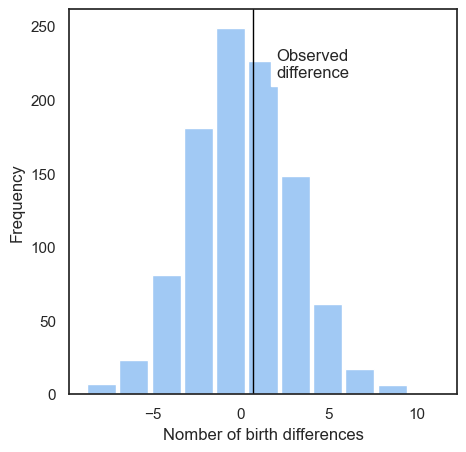

In [17]:
# we work on the rolling mean values of both periods
mean_moon = df_moon_value.smooth_rolling_mean.mean()
mean_regular = df_normal_value.smooth_rolling_mean.mean()
print(f"Observed difference of means : {mean_moon - mean_regular}\n")

nA = len(df_stats.loc[df_stats.type == "moon"])
nB = len(df_stats.loc[df_stats.type == "regular"])
perm_diffs = [perm_fun(df_stats.smooth_rolling_mean, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=mean_moon - mean_regular, color="black", lw=1)
ax.text(2, 215, "Observed\ndifference", bbox={"facecolor": "white"})
ax.set_xlabel("Fig 9 : Number of birth differences")
ax.set_ylabel("Frequency")

# p-value represent number of times we could expect the random model to have more extrem results than observed repartition (by chance)
# here we have larger differences of child birth in 40% of time, far from 5% alpha
print(
    f"Percentage of times random permutation mean exceed obeserved difference (p-value) : {np.mean(perm_diffs > mean_moon - mean_regular)*100} %"
)


# We don't reach level of significancy : random permutation exceed observation more than 5% of the time
# coherent with the small difference between means of the two sets

In [18]:
# calculating p-value with sci-py t-test (approximation of permutation test with distribution)
res = stats.ttest_ind(
    df_moon_value.smooth_rolling_mean,
    df_normal_value.smooth_rolling_mean.dropna(),
    equal_var=False,
)  # when 2 population are not same size or same variance

print(f"p-value for single sided test : {res.pvalue / 2:.4f}")

p-value for single sided test : 0.3896


The result is far from significant... Manually calculated or using scipy function, the random permutation exceed observed difference on more than 38% of the time. We can easily conclude that there is no significante difference of childbirth giving between full moon periods and the rest of the year. 

Of course, this little study does not stand as general truth. It is mainly a quick manipulation of data and statistical elements. To accuratly respond to our hypothesis, a larger study would be needed, excluding induced childbirth from the data and integrating more than one year. It also would be instructive to handle thiner geographical area, to observe differencesbetween rural area and bigger cities. 